# _setup

## Package management

In [33]:
# --- Standard library ---
import os
import sys
from enum import Enum

# --- Network science ---
import networkx as nx

# --- Scientific computing ---
import numpy as np
from sklearn import manifold

# --- Data handling and visualization ---
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

import seaborn as sns

# --- Miscelleaneous ---
from tqdm.auto import tqdm

# --- Project source code ---
## PATH adjustments
FP_ROOT = os.path.join("..", "..", "")
FP_SRC = os.path.join(FP_ROOT, "src", "")
sys.path.append(FP_ROOT)
sys.path.append(FP_SRC)

## Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import generate_multiplex_LFR  # benchmark samplers

## Embedding
from src.embed.N2V import N2V
from src.embed.helpers import get_components

## Sampling
from src.sampling.random import partial_information  # PFI observation

## Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

## Hypercompare - Isomap
from src.hypercomparison import networks

## Global Config

In [34]:
# * Pathing aliases
FP_REMNANTS = os.path.join(FP_ROOT, "data", "input", "edgelists", "")
FP_DFS = os.path.join(FP_ROOT, "data", "output", "dataframes", "")
FP_FIGS = os.path.join(FP_ROOT, "data", "output", "figures", "")

In [35]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

# Experiment

## Preparations

### Initializaing parameters

In [36]:
# --- Data/Experiment Configurations ---
class NetworkParams(Enum):
    # Shared params
    N = 1000
    PROB = 1.0
    T1 = 2.1
    KMAX = np.sqrt(1000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    KAVG = 5.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 11, endpoint=True)

LOGREG = {
    "fit_intercept": True,  # include intercept accounting for class imbalance
    "solver": "newton-cholesky",  # uses Cholesky-decomposition to approximate Hessian for Newton-esque method
    "penalty": None  # do not include coefficient regularization
}

### Defining functions

In [37]:
"""
Implementations of Isomap
Metric MDS + shortest path length matrix of a network
"""
class MDSBase:
    def __init__(self, dimension):
        self.dimension = dimension

    def train(self, network):
        self.network = network
        self.network.generate_shortest_path_length_matrix()
        self.embeddings_matrix = self._get_embedding()

        if len(self.embeddings_matrix) == 0:
            self.embeddings = {}
        else:
            self.embeddings = {
                self.network.id2node[i]: self.embeddings_matrix[i] for i in range(len(self.network.id2node))
            }
        return self.embeddings


class Isomap(MDSBase):
    def __init__(self, dimension=2):
        super(Isomap, self).__init__(dimension)

    def _get_embedding(self):
        return manifold.MDS(
            self.dimension, dissimilarity="precomputed").fit_transform(
                self.network.shortest_path_length_matrix)

In [38]:
"""Network initialization
"""
def get_network(
        N=int(NetworkParams.N.value),  # number of nodes
        T1=NetworkParams.T1.value,  # degree distribution exponent
        T2=NetworkParams.T2.value,  # community size distribution exponent
        MU=NetworkParams.MU.value,  # community mixing parameter
        KAVG=NetworkParams.KAVG.value,  # average degree
        KMAX=NetworkParams.KMAX.value,  # maximum degree
        MIN_COMMUNITY=NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
        PROB=NetworkParams.PROB.value,  # degree sequence correlation,
        ROOT="../../"):
    duplex, _, _, _ = generate_multiplex_LFR(N, T1, T2, MU, KAVG, KMAX, MIN_COMMUNITY, PROB, ROOT)
    duplex = duplex_network(duplex, 1, 2, verbose=True)

    return duplex

def get_network_debug(
        N=int(NetworkParams.N.value),  # number of nodes
        T1=NetworkParams.T1.value,  # degree distribution exponent
        T2=NetworkParams.T2.value,  # community size distribution exponent
        MU=NetworkParams.MU.value,  # community mixing parameter
        KAVG=NetworkParams.KAVG.value,  # average degree
        KMAX=NetworkParams.KMAX.value,  # maximum degree
        MIN_COMMUNITY=NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
        PROB=NetworkParams.PROB.value,  # degree sequence correlation,
        ROOT="../../"):
    G = nx.erdos_renyi_graph(N, KAVG/N)
    H = nx.erdos_renyi_graph(N, KAVG/N)
    duplex = {1: G, 2: H}
    duplex = duplex_network(duplex, 1, 2, verbose=True)

    return duplex

def get_remnants(theta, G, H):
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)

    return remnant_G, remnant_H, test_edges, train_edges

def prepare_system(theta):
    G, H = get_network()
    remnants_data = get_remnants(theta, G, H)

    return remnants_data

In [39]:
"""Features
"""
# --- Degrees ---
def get_degree_features(remnants_data):
    G, H, E_test, E_train = remnants_data
    G, H = G.remnant, H.remnant

    src_G, tgt_G = get_degrees(G, E_train)
    src_H, tgt_H = get_degrees(H, E_train)
    degree_products_G_train = src_G * tgt_G
    degree_products_H_train = src_H * tgt_H

    feature_degrees_train = as_configuration(degree_products_G_train, degree_products_H_train)

    src_G, tgt_G = get_degrees(G, E_test)
    src_H, tgt_H = get_degrees(H, E_test)
    degree_products_G_test = src_G * tgt_G
    degree_products_H_test = src_H * tgt_H

    feature_degrees_test = as_configuration(degree_products_G_test, degree_products_H_test)

    return feature_degrees_train, feature_degrees_test

# --- Embedding ---
def get_distance_features(
        remnants_data,
        per_component=False):
    g, h, E_test, E_train = remnants_data
    g, h = g.remnant, h.remnant

    # Cast as NetworkBase class object for hypercomparison
    G_ = networks.NetworkBase()
    H_ = networks.NetworkBase()
    G_.G = g
    H_.G = h
    G_.convert_to_undirected()
    H_.convert_to_undirected()

    embeddings_G = Isomap(dimension=128).train(G_)
    embeddings_H = Isomap(dimension=128).train(H_)

    distances_G_train = get_distances(embeddings_G, E_train)
    distances_H_train = get_distances(embeddings_H, E_train)
    distances_G_test = get_distances(embeddings_G, E_test)
    distances_H_test = get_distances(embeddings_H, E_test)

    feature_distances_train = as_configuration(distances_G_train, distances_H_train)
    feature_distances_test = as_configuration(distances_G_test, distances_H_test)

    return feature_distances_train, feature_distances_test

def get_distance_features_N2V(
        remnants_data,
        per_component=False):
    G, H, E_test, E_train = remnants_data
    G, H = G.remnant, H.remnant

    embeddings_G = N2V(G, {"quiet": True}, dict())
    embeddings_H = N2V(H, {"quiet": True}, dict())
    # embeddings_G.normalize(get_components(G))
    # embeddings_G.normalize(get_components(H))
    embeddings_G = embeddings_G.vectors
    embeddings_H = embeddings_H.vectors
    vectors = (embeddings_G, embeddings_H)

    distances_G_train = get_distances(embeddings_G, E_train)
    distances_H_train = get_distances(embeddings_H, E_train)
    distances_G_test = get_distances(embeddings_G, E_test)
    distances_H_test = get_distances(embeddings_H, E_test)
    distances = (distances_G_train, distances_H_train, distances_G_test, distances_H_test)

    feature_distances_train = as_configuration(distances_G_train, distances_H_train)
    feature_distances_test = as_configuration(distances_G_test, distances_H_test)

    return feature_distances_train, feature_distances_test, distances, vectors

def get_features(remnants_data):
    feature_degrees_train, feature_degrees_test = get_degree_features(remnants_data)
    feature_distances_train, feature_distances_test = get_distance_features(remnants_data)

    X_train = format_feature_matrix((feature_degrees_train, feature_distances_train))
    X_test = format_feature_matrix((feature_degrees_test, feature_distances_test))

    Y_train = get_labels(remnants_data[-1])
    Y_test = get_labels(remnants_data[-2])

    return (X_train, Y_train), (X_test, Y_test)

def get_features_debug(remnants_data):
    # feature_degrees_train, feature_degrees_test = get_degree_features(remnants_data)
    feature_distances_train, feature_distances_test, distances, vectors = get_distance_features_N2V(remnants_data)

    # ! >>> DEBUG >>>
    # X_train = format_feature_matrix((feature_degrees_train, feature_distances_train))
    # X_test = format_feature_matrix((feature_degrees_test, feature_distances_test))
    # ! ---
    X_train = np.array(feature_distances_train).reshape(-1,1)
    X_test = np.array(feature_distances_test).reshape(-1,1)
    # ! ---
    # X_train = np.array(feature_degrees_train).reshape(-1,1)
    # X_test = np.array(feature_degrees_test).reshape(-1,1)
    # ! <<< DEBUG <<<

    Y_train = get_labels(remnants_data[-1])
    Y_test = get_labels(remnants_data[-2])

    return (X_train, Y_train), (X_test, Y_test), distances, vectors

In [40]:
"""Reconstruction as classification
"""
def train_model(X_train, Y_train):
    model = LogReg("LogReg", ("degrees", "distances"), dict(), X_train, Y_train, LOGREG)
    return model

def train_model_debug(X_train, Y_train):
    # ! >>> DEBUG >>>
    # model = LogReg("LogReg", ("degrees", "distances"), dict(), X_train, Y_train, LOGREG)
    # ! ---
    model = LogReg("LogReg", tuple(["distances"]), dict(), X_train, Y_train, LOGREG)
    # ! <<< DEBUG <<<
    return model

def reconstruct(model, X_test, Y_test):
    predicted_labels = model.get_reconstruction(X_test)
    scored_labels = model.get_scores(X_test)
    acc = performance(scored_labels, predicted_labels, Y_test, "accuracy")
    auc = performance(scored_labels, predicted_labels, Y_test, "AUC")
    pr = performance(scored_labels, predicted_labels, Y_test, "PR")

    return (acc, auc, pr)

def get_performances(X_train, Y_train, X_test, Y_test):
    model = train_model(X_train, Y_train)
    perfs = reconstruct(model, X_test, Y_test)

    return perfs

def get_performances_debug(X_train, Y_train, X_test, Y_test):
    model = train_model_debug(X_train, Y_train)
    perfs = reconstruct(model, X_test, Y_test)

    return perfs, model


### Defining main

In [41]:
def analysis(parameters):
    # >>> Book-keeping >>>
    # Unpack paramaters
    ## Ensure safety with downstream unpacking
    if "network" not in parameters:
        parameters.update({"network": {}})

    # Initialize output structs
    records = []

    # Initialize topology used across thetas
    G, H = get_network(**parameters["network"])
    # <<< Book-keeping <<<

    # >>> Sweep >>>
    for theta in tqdm(ExperimentParams.THETAS.value, desc="Preliminary Isomap Reconstruction"):
        # Observe remnant at given theta
        remnants_data = get_remnants(theta, G, H)

        # Get features
        features_train, features_test = get_features(remnants_data)
        X_train, Y_train = features_train
        X_test, Y_test = features_test

        # Reconstruct mulitplex
        acc, auc, pr = get_performances(X_train, Y_train, X_test, Y_test)

        records.append({
            "theta": theta,
            "acc": acc,
            "auc": auc,
            "pr": pr
        })
    # <<< Sweep <<<

    df = pd.DataFrame.from_records(records)
    return df

def analysis_debug(parameters):
    # >>> Book-keeping >>>
    # Unpack paramaters
    ## Ensure safety with downstream unpacking
    if "network" not in parameters:
        parameters.update({"network": {}})

    # Initialize output structs
    records = []

    # Initialize topology used across thetas
    # ! >>>
    # G, H = get_network_debug(**parameters["network"])
    # ! ---
    G, H = get_network(**parameters["network"])
    # ! <<<
    # <<< Book-keeping <<<

    # >>> Sweep >>>
    models = []
    distances = []
    vectors = []
    for theta in tqdm(ExperimentParams.THETAS.value, desc="DEBUG Preliminary Isomap Reconstruction"):
        # Observe remnant at given theta
        remnants_data = get_remnants(theta, G, H)

        # Get features
        features_train, features_test, distance, vector = get_features_debug(remnants_data)
        X_train, Y_train = features_train
        X_test, Y_test = features_test

        # Reconstruct mulitplex
        (acc, auc, pr), model = get_performances_debug(X_train, Y_train, X_test, Y_test)

        records.append({
            "theta": theta,
            "acc": acc,
            "auc": auc,
            "pr": pr
        })
        models.append(model)
        distances.append(distance)
        vectors.append(vector)
    # <<< Sweep <<<

    df = pd.DataFrame.from_records(records)
    return df, models, distances, vectors

## Calculations

### Final setup

### Running main experiment

In [42]:
# df, models, distances, vectors = analysis_debug(dict())
df = analysis(dict())

Number of common edges removed: 17
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 1
Size of active node set union from layers 1 and 2: 1999


Preliminary Isomap Reconstruction: 100%|██████████| 11/11 [12:42<00:00, 69.31s/it]


In [43]:
# df.to_csv("dataframe_prelim-isomap.csv", index=False)

# Analysis

## Preprocessing

In [44]:
# df = pd.read_csv("dataframe_prelim-isomap.csv")
# df.head()

In [45]:
df = df.melt(id_vars=["theta"], value_vars=["acc", "auc", "pr"], var_name="performance")
df.head()

,theta,performance,value
0,0.05,acc,0.608964
1,0.14,acc,0.634195
2,0.23,acc,0.689392
3,0.32,acc,0.732695
4,0.41,acc,0.768284


## Visualizations

<Figure size 800x600 with 0 Axes>

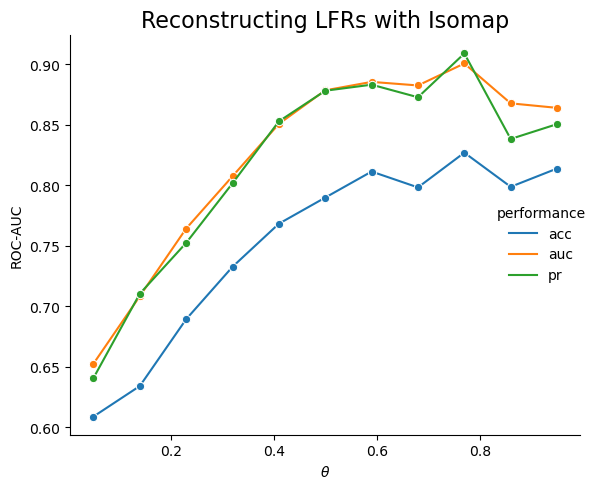

In [46]:
# Instantiate figure, subset relevant data
fig = plt.figure()

# Plotting data
sns.relplot(
    data=df, kind="line",
    x="theta", y="value",
    hue="performance",
    marker="o"
)

# Axes configuration
plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")


# Figure-level attributes
plt.title("Reconstructing LFRs with Isomap")

# Save plot
plt.tight_layout()
# plt.savefig(f"{FP_FIGS}/line_auroc-pfi_prelim-isomap.png")